<a href="https://colab.research.google.com/github/AhmedKhalid37/SIC-GROUP-27/blob/main/SIC_27.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
mbsoroush_car_camera_photos_path = kagglehub.dataset_download('mbsoroush/car-camera-photos')

print('Data source import complete.')


In [ ]:
!pip install ultralytics

Searching for images in /kaggle/input...
Processing 3 images...

0: 416x640 1 person, 5 cars, 4.7ms
1: 416x640 6 cars, 4.7ms
2: 416x640 4 cars, 4.7ms
Speed: 1.4ms preprocess, 4.7ms inference, 0.9ms postprocess per image at shape (1, 3, 416, 640)
SELF-DRIVING SAFETY REPORT
LEGEND: [VC]=Very Close (<15m) | [C]=Close (<45m)
[N]=Normal | [O]=Other Lane
------------------------------------------------------------
Scenario 1:
   Object 1: 9.3m 	-> Code: [VC] Action: BRAKE
   Object 2: 15.9m 	-> Code: [O] Action: IGNORE
   Object 3: 38.6m 	-> Code: [O] Action: IGNORE
--------------------
Scenario 2:
   Object 1: 40.8m 	-> Code: [O] Action: IGNORE
   Object 2: 86.4m 	-> Code: [O] Action: IGNORE
   Object 3: 93.9m 	-> Code: [O] Action: IGNORE
--------------------
Scenario 3:
   Object 1: 30.0m 	-> Code: [C] Action: SLOW
   Object 2: 80.0m 	-> Code: [F] Action: SAFE
   Object 3: 86.4m 	-> Code: [F] Action: SAFE
--------------------


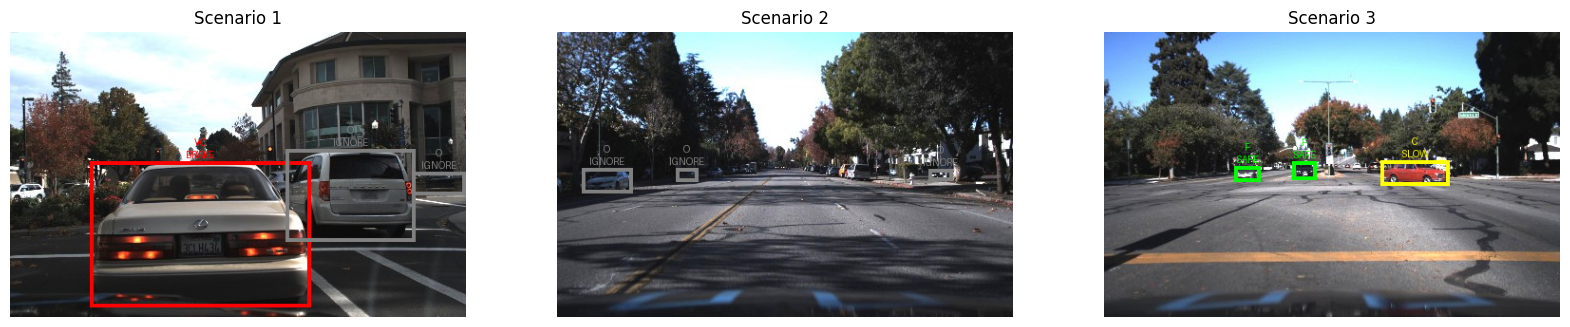

In [ ]:
import os
import glob
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
from collections import Counter

# 1. Load Model
model = YOLO('yolov8n.pt')

# 2. Constants
KNOWN_WIDTH = 1.8
FOCAL_LENGTH = 1200

# 3. Logic Functions
def get_distance(box_width_px):
    if box_width_px == 0: return 999.0
    return (KNOWN_WIDTH * FOCAL_LENGTH) / box_width_px

def get_status(dist, x_center, img_width):
    lane_min = img_width * 0.3
    lane_max = img_width * 0.7

    if x_center < lane_min or x_center > lane_max:
        return "O", "IGNORE", (128, 128, 128)

    if dist < 15.0:
        return "VC", "BRAKE", (255, 0, 0)
    elif dist < 45.0:
        return "C", "SLOW", (255, 255, 0)
    elif dist < 70.0:
        return "N", "SAFE", (0, 255, 0)
    else:
        return "F", "SAFE", (0, 255, 0)

def load_fonts():
    possible_fonts = [
        "/usr/share/fonts/truetype/dejavu/DejaVuSans-Bold.ttf",
        "arial.ttf",
        "Arial.ttf"
    ]
    font_large = None
    font_small = None

    for f_path in possible_fonts:
        try:
            font_large = ImageFont.truetype(f_path, 40)
            font_small = ImageFont.truetype(f_path, 15)
            break
        except IOError:
            continue

    if font_large is None:
        font_large = ImageFont.load_default()
        font_small = ImageFont.load_default()

    return font_large, font_small

# ==========================================
# PART 4: FIND & PROCESS IMAGES DIRECTLY
# ==========================================

# 1. Find all images in the Input directory
print("Searching for images in /kaggle/input...")
all_images = glob.glob('/kaggle/input/**/*.jpg', recursive=True) + \
             glob.glob('/kaggle/input/**/*.png', recursive=True)

if not all_images:
    print("No images found. Make sure you added a dataset!")
else:
    # 2. Pick 3 Random Images directly from the source
    # We use min() to ensure we don't crash if there are fewer than 3 images
    selected_files = random.sample(all_images, min(3, len(all_images)))

    print(f"Processing {len(selected_files)} images...")
    results = model(selected_files)

    # --- PRINT TEXT REPORT ---
    print("="*60)
    print("SELF-DRIVING SAFETY REPORT")
    print("="*60)
    print("LEGEND: [VC]=Very Close (<15m) | [C]=Close (<45m)")
    print("[N]=Normal | [O]=Other Lane")
    print("-" * 60)

    plt.figure(figsize=(20, 10))

    font_large, font_small = load_fonts()

    for i, r in enumerate(results):
        img_bgr = r.orig_img.copy()
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        pil_img = Image.fromarray(img_rgb)
        draw = ImageDraw.Draw(pil_img)

        img_h, img_w = pil_img.size[1], pil_img.size[0]

        detected_cars = []
        boxes = r.boxes
        for box in boxes:
            cls_id = int(box.cls[0])
            if cls_id in [2, 3, 5, 7]:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                w_box = x2 - x1
                c_x = (x1 + x2) / 2

                dist = get_distance(w_box)
                code, action, color = get_status(dist, c_x, img_w)

                detected_cars.append({
                    'dist': dist,
                    'coords': (x1, y1, x2, y2),
                    'color': color,
                    'code': code,
                    'action': action
                })

        detected_cars.sort(key=lambda x: x['dist'])
        top_3_cars = detected_cars[:3]

        print(f"Scenario {i+1}:")
        if not top_3_cars: print("   (No vehicles detected)")
        for idx, car in enumerate(top_3_cars):
            d = car['dist']
            c = car['code']
            a = car['action']
            print(f"   Object {idx+1}: {d:.1f}m \t-> Code: [{c}] Action: {a}")
        print("-" * 20)

        for car in top_3_cars:
            code_text = car['code']
            action_text = car['action']
            color = car['color']
            x1, y1, x2, y2 = car['coords']
            w_box = x2 - x1

            draw.rectangle([x1, y1, x2, y2], outline=color, width=4)

            bbox_code = draw.textbbox((0, 0), code_text, font=font_large)
            w_code = bbox_code[2] - bbox_code[0]
            h_code = bbox_code[3] - bbox_code[1]

            bbox_action = draw.textbbox((0, 0), action_text, font=font_small)
            w_action = bbox_action[2] - bbox_action[0]
            h_action = bbox_action[3] - bbox_action[1]

            box_center_x = x1 + (w_box / 2)
            x_code = box_center_x - (w_code / 2)
            x_action = box_center_x - (w_action / 2)

            padding = 5
            y_action = y1 - h_action - padding
            y_code = y_action - h_code - padding

            if y_code < 0:
                y_code = y1 + padding
                y_action = y_code + h_code + padding

            draw.text((x_code, y_code), code_text, fill=color, font=font_large)
            draw.text((x_action, y_action), action_text, fill=color, font=font_small)

        plt.subplot(1, 3, i+1)
        plt.imshow(pil_img)
        plt.axis('off')
        plt.title(f"Scenario {i+1}")

    plt.show()